In [1]:
!pip install torch transformers datasets -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.


In [2]:
from datasets import load_dataset

imagenette = load_dataset("frgfm/imagenette", "full_size", split='train')
imagenette

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


0000.parquet:   0%|          | 0.00/506M [00:00<?, ?B/s]

0001.parquet:   0%|          | 0.00/509M [00:00<?, ?B/s]

0002.parquet:   0%|          | 0.00/87.0M [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/463M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/9469 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3925 [00:00<?, ? examples/s]

Dataset({
    features: ['image', 'label'],
    num_rows: 9469
})

In [3]:
# checking out the labels and classes
print(imagenette.features['label'].names)

['tench', 'English springer', 'cassette player', 'chain saw', 'church', 'French horn', 'garbage truck', 'gas pump', 'golf ball', 'parachute']


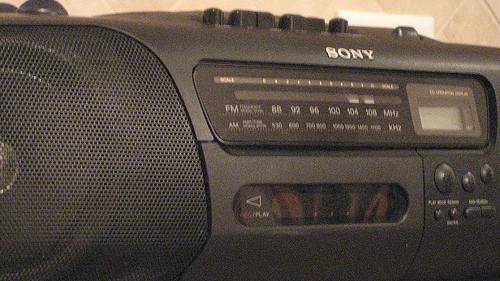

In [4]:
# Looking at the first image.
imagenette[0]['image']

In [5]:
from transformers import CLIPTokenizerFast, CLIPProcessor, CLIPModel
import torch

# Set device agnostic code
device = "cuda" if torch.cuda.is_available() else \
         ("mps" if torch.backends.mps.is_available() else "cpu")

model_id = 'openai/clip-vit-base-patch32'

model = CLIPModel.from_pretrained(model_id).to(device)  # The actual model
tokenizer = CLIPTokenizerFast.from_pretrained(model_id) # Text to embeddings
processor = CLIPProcessor.from_pretrained(model_id)     # Image to embeddings

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

In [6]:
prompt = "a music playing device"

# tokenize the prompt
inputs = tokenizer(prompt, return_tensors='pt')
inputs

{'input_ids': tensor([[49406,   320,  1179,  1629,  8163, 49407]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1]])}

The attention mask has all 1s. If we had padding, anything beyond the length of our prompt would be 0, telling the model to not pay attention to it.

In [9]:

text_emb = model.get_text_features(**inputs)
text_emb.shape

torch.Size([1, 512])

In [10]:
image = processor(
    text=None,
    images=imagenette[0]['image'],
    return_tensors='pt'
)

image


{'pixel_values': tensor([[[[ 1.7552,  1.7698,  1.8135,  ...,  1.6968,  1.7114,  1.6530],
          [ 1.7406,  1.7698,  1.7406,  ...,  1.6384,  1.6238,  1.6968],
          [ 1.6530,  1.6968,  1.6968,  ...,  1.6384,  1.6530,  1.6530],
          ...,
          [-1.4273, -1.3105, -1.2667,  ..., -1.1353, -1.0915, -1.1207],
          [-1.1353, -1.3251, -1.3251,  ..., -1.2667, -1.2083, -1.1207],
          [-0.9018, -1.2667, -1.3251,  ..., -1.1499, -1.1061, -1.1937]],

         [[ 1.4446,  1.3995,  1.5046,  ...,  1.2945,  1.3245,  1.3095],
          [ 1.4295,  1.4145,  1.4295,  ...,  1.2945,  1.2344,  1.2945],
          [ 1.3545,  1.3845,  1.3845,  ...,  1.2795,  1.3095,  1.2795],
          ...,
          [-1.3469, -1.1968, -1.2418,  ..., -1.1368, -1.1218, -1.1818],
          [-1.0918, -1.2268, -1.2268,  ..., -1.1668, -1.1668, -1.1668],
          [-0.8816, -1.1818, -1.1818,  ..., -1.1068, -1.1368, -1.2268]],

         [[ 1.0794,  1.1078,  1.1078,  ...,  1.0083,  1.0083,  0.8803],
          [ 1

In [11]:
image = image['pixel_values'] # Getting the image because processor outputs a dict.
image.shape

torch.Size([1, 3, 224, 224])

In [12]:
image.squeeze(0).permute(1, 2, 0).shape # We need to reshape the image to display using matplotlib


torch.Size([224, 224, 3])

(-0.5, 223.5, 223.5, -0.5)

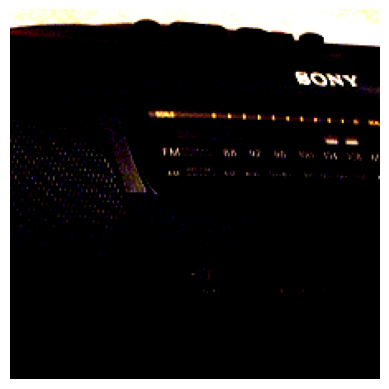

In [14]:
import matplotlib.pyplot as plt

plt.imshow(image.squeeze(0).permute(1, 2, 0))
plt.axis("off")


In [15]:
# Converting the image to image embedding format which the CLIP model expects.
image_emb = model.get_image_features(image)
image_emb.shape

torch.Size([1, 512])

In [16]:
import numpy as np

# Setting random seed
np.random.seed(42)

# Picking 100 random indices.
sample_idx = np.random.randint(0, len(imagenette)+1, 100).tolist()
images = [imagenette[i]['image'] for i in sample_idx]
len(images)


100

In [17]:
from tqdm.auto import tqdm

batch_size = 32
image_arr = None

for i in tqdm(range(0, len(images), batch_size)):
  # Select batch of images
  batch = images[i:i+batch_size]
  # Process the batch and resize as required.
  batch = processor(
      text=None,
      images=batch,
      return_tensors='pt',
      padding=True
  )['pixel_values'].to(device)  # (32, 3, 224, 224)
  # Get image embeddings
  batch_emb = model.get_image_features(pixel_values=batch)  # (32, 512)
  # Convert to numpy array
  batch_emb = batch_emb.cpu().detach().numpy()
  # Add to larger array of all image embeddings
  if image_arr is None:
    image_arr = batch_emb
  else:
    image_arr = np.concatenate((image_arr, batch_emb), axis=0)

image_arr.shape

  0%|          | 0/4 [00:00<?, ?it/s]

(100, 512)

In [18]:
# This contains the L2 norm calculated across axis 1.
# Since our embeddings are in the shape (100, 512), we calculate L2 norm of each embedding.
# Thus, we get 100 L2 norm values here.
np.linalg.norm(image_arr, axis=1), np.linalg.norm(image_arr, axis=1).shape # 100 values

(array([ 9.529713 , 10.508784 , 10.683978 ,  9.65753  , 10.54378  ,
        10.011744 , 11.470619 , 10.142127 , 11.241701 , 10.300415 ,
         9.616388 , 10.753281 , 10.079945 , 10.226763 , 10.50327  ,
        10.242999 ,  9.705637 ,  9.584946 ,  9.724624 ,  8.978424 ,
        10.452248 , 10.888628 ,  9.463259 ,  9.970941 , 10.224886 ,
        10.35886  , 10.867866 , 11.160348 ,  9.618789 , 10.565284 ,
         8.950005 , 10.583959 ,  9.8902235, 10.657272 , 10.818478 ,
         9.497438 , 10.457944 , 10.451728 , 10.914341 , 10.107171 ,
        10.473815 , 10.817263 ,  9.721801 , 11.373078 , 11.209728 ,
        10.352364 , 10.33911  ,  9.949795 ,  9.933689 , 10.518985 ,
        10.796502 ,  9.973121 , 11.105112 , 10.580153 , 10.070488 ,
         9.859064 , 10.146965 ,  9.309978 , 10.220114 , 10.844063 ,
        10.539926 , 10.50533  , 10.488182 , 10.158248 , 11.076652 ,
        10.675408 , 10.441277 ,  8.626151 , 10.358962 , 11.817947 ,
         9.780078 , 10.687835 , 10.2537565, 10.2

In [19]:
# Taking transpose so embedding becomes column, each row has 100 embeddings, each for a single image
# Now, we divide 100 embeddings with their respective L2 norm values to normalize.
image_arr = image_arr.T / np.linalg.norm(image_arr, axis=1)
image_arr.shape

(512, 100)

In [20]:
image_arr = image_arr.T # Taking transpose again to get it in correct shape for CLIP.
image_arr.shape, image_arr.min(), image_arr.max()

((100, 512), -0.7828414, 0.3729747)

In [21]:
# Converting text embedding to numpy array.
text_emb = text_emb.cpu().detach().numpy()  # (1, 512)

In [22]:
# Finding dot product similarity
scores = np.dot(text_emb, image_arr.T)
scores.shape

(1, 100)

In [23]:
# Getting the index locations having the highest 5 similarity scores.
idx = np.argsort(-scores[0])[:5]  # -scores[0] because we want sorting in descending order
idx

array([38, 22, 73, 43, 82])

3.1725023


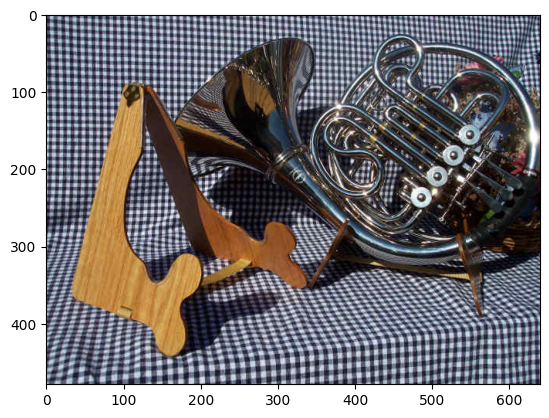

3.0859241


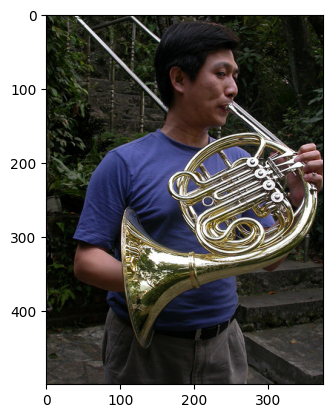

3.011205


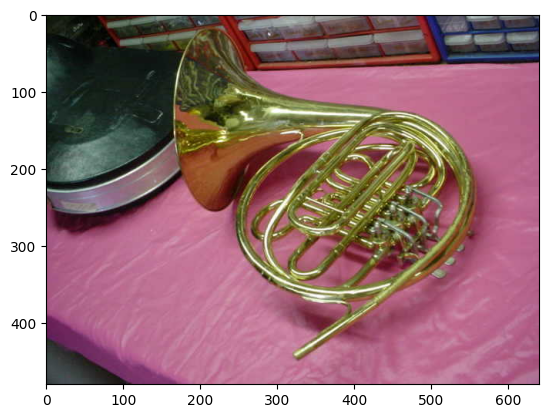

2.9760199


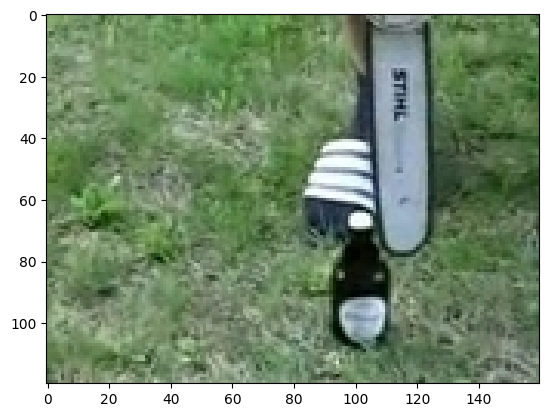

2.975769


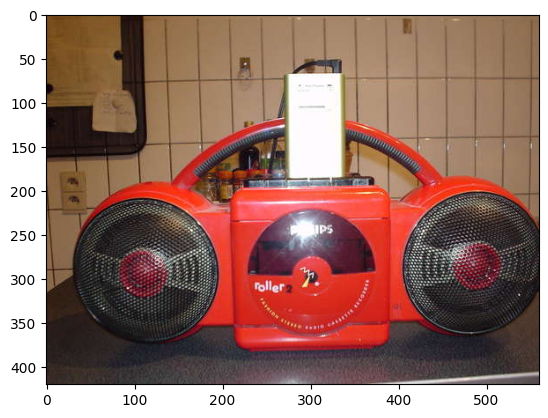

In [24]:
# Displaying the images which have the highest similarity to the prompt.
for i in idx:
  print(scores[0][i])
  plt.imshow(images[i])
  plt.show()
